## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity from 201905 runs to DFO observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [ ]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
year=2007

In [2]:

start_date = dt.datetime(year,3,1)
end_date = dt.datetime(year,5,31)### temporary to be quick!!!
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO(datelims=(start_date,end_date))
print(len(df1))
df1[['Year','Month','Day','Lat','Lon','Pressure','Depth','N','Si','Chlorophyll_Extracted','ConsT','AbsSal']].head()

423


,Year,Month,Day,Lat,Lon,Pressure,Depth,N,Si,Chlorophyll_Extracted,ConsT,AbsSal
0,2007.0,3.0,28.0,50.655333,-126.183,2.1,None,23.1,49.0,NaN,7.240257,28.188000
1,2007.0,3.0,28.0,50.655333,-126.183,11.5,None,24.0,48.3,NaN,7.299872,28.999398
2,2007.0,3.0,28.0,50.655333,-126.183,20.8,None,23.5,45.4,NaN,7.284357,30.329878
3,2007.0,3.0,28.0,50.655333,-126.183,31.3,None,25.5,48.9,NaN,7.286863,30.416127
4,2007.0,3.0,28.0,50.655333,-126.183,51.0,None,26.5,50.4,NaN,7.370615,30.606657


In [3]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1)

(Lat,Lon)= 50.605333333333334 -126.3565  not matched to domain
(Lat,Lon)= 50.635 -126.425  not matched to domain
(Lat,Lon)= 50.65533333333333 -126.183  not matched to domain
(Lat,Lon)= 50.66983333333334 -126.067  not matched to domain
(Lat,Lon)= 50.693666666666665 -125.78316666666667  not matched to domain
(Lat,Lon)= 50.72666666666667 -126.182  not matched to domain
(Lat,Lon)= 50.784 -126.61366666666666  not matched to domain
(Lat,Lon)= 50.813 -126.52483333333333  not matched to domain
(Lat,Lon)= 50.84 -126.33  not matched to domain
(Lat,Lon)= 50.93633333333333 -126.4815  not matched to domain
(Lat,Lon)= 51.018 -126.523  not matched to domain


In [4]:
# do density calculation here:
data['rho']=gsw.rho(data['AbsSal'],data['ConsT'],data['Pressure'])
data['mod_rho']=gsw.rho(data['mod_vosaline'],data['mod_votemper'],
                        gsw.p_from_z(-1*data['Z'],data['Lat']))

In [5]:
cm1=cmocean.cm.thermal
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


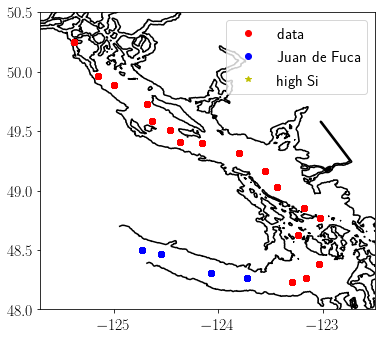

In [6]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [7]:
mod_chl_N=2.0
#mod_chl_N=1.6
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

# Nitrate

In [8]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N_d50, modmean_d50, obsmean_d50, bias_d50, RMSE_d50, WSS_d50 = et.stats(data.loc[data.Z>50,['N']],data.loc[data.Z>50,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('z>50 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d50,bias_d50,RMSE_d50,WSS_d50))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 60
  bias: 2.6827924982706683
  RMSE: 5.13338034523671
  WSS: 0.5300260822788176
15 m<=z<22 m:
  N: 20
  bias: 0.485174369812011
  RMSE: 2.299147015466808
  WSS: 0.3019194222032737
z>=22 m:
  N: 195
  bias: -0.7578912157890088
  RMSE: 2.57863142462168
  WSS: 0.6271677254976832
z>50 m:
  N: 155
  bias: -0.7722159847136467
  RMSE: 2.6278999537952688
  WSS: 0.5846920255343238
all:
  N: 275
  bias: 0.08320818259499418
  RMSE: 3.2937618563777127
  WSS: 0.7322660011139395


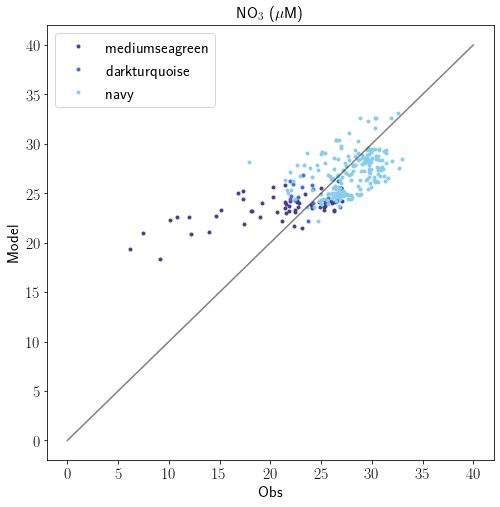

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.plot((0,40),(0,40),'k-',alpha=.5)

Nitrate, z<15
Jan-Mar:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
April:
  N: 60
  bias: 2.6827924982706683
  RMSE: 5.13338034523671
  WSS: 0.5300260822788176
May-Aug:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
Sep-Dec:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan


/home/eolson/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eolson/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:968: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:969: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)
/home/eolson/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was 

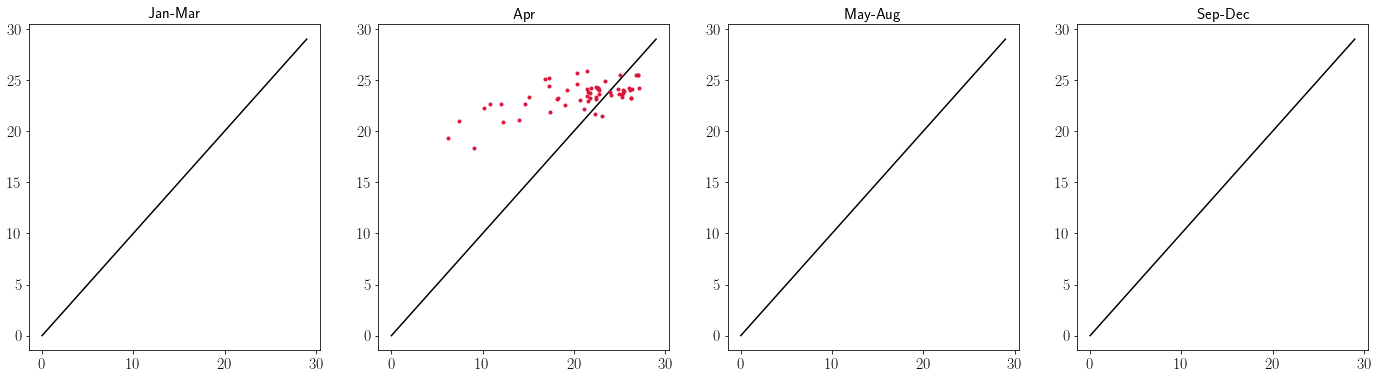

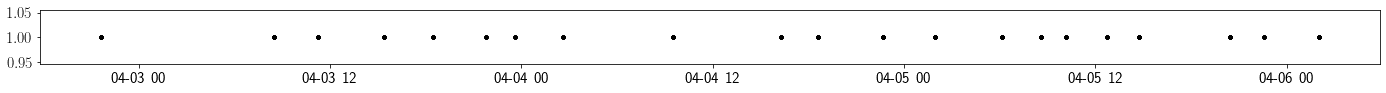

In [10]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Jan-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('Apr')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Aug')
ii3=(data.Z < 15)&(data.dtUTC>dt.datetime(year,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Dec')

#ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,4,1))&(data.dtUTC>dt.datetime(2016,2,1))
#ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
#ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,5,1))&(data.dtUTC>dt.datetime(2016,4,1))
#ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))

print('Nitrate, z<15')
print('Jan-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Aug:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Dec:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


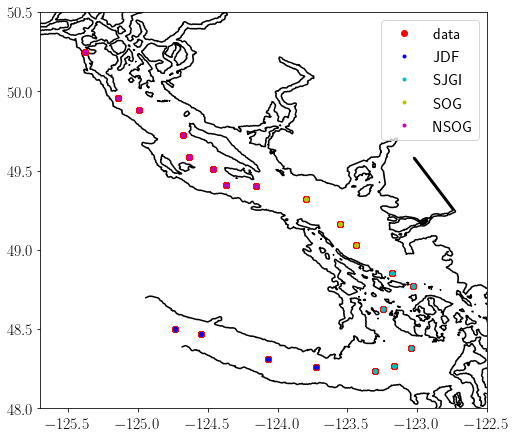

In [11]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

Text(0.5, 1.0, 'NO$_3$ ($\\mu$M)')

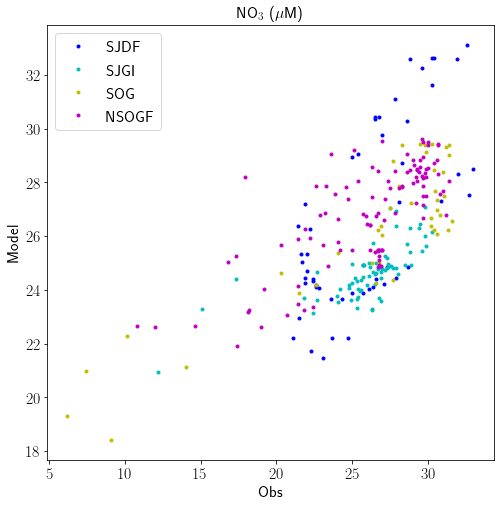

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

(-40, 20)

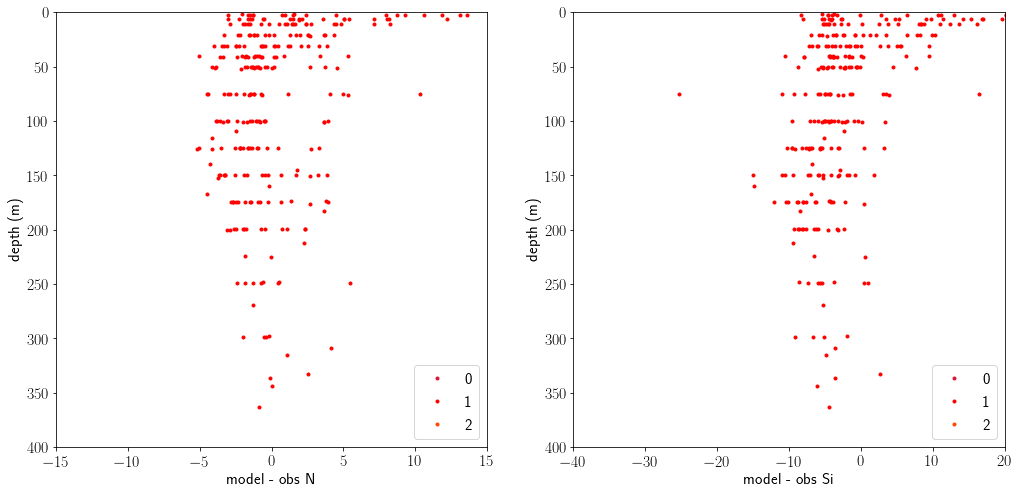

In [13]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan','darkturquoise','royalblue',
      'lightskyblue','blue','darkblue','mediumslateblue','blueviolet','darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-40,20)

Text(0, 0.5, 'Nitrate Error')

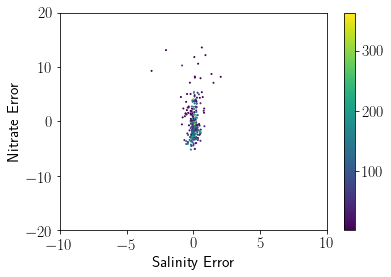

In [14]:
m=plt.scatter(data['mod_vosaline']-data['AbsSal'],data['mod_nitrate']-data['N'],c=data['Z'],s=1)
plt.colorbar(m)
plt.xlim(-10,10)
plt.ylim(-20,20)
plt.xlabel('Salinity Error')
plt.ylabel('Nitrate Error')

# dSi

In [15]:
print('dSi')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')
print('obs Si < 50:')
et.printstats(data.loc[data.Si<50,:],'Si','mod_silicon')

dSi
z<15 m:
  N: 60
  bias: 5.894643719991031
  RMSE: 11.771290063713918
  WSS: 0.2774511539938447
15 m<=z<22 m:
  N: 20
  bias: 0.4755932617187568
  RMSE: 5.378081033274295
  WSS: 0.5464685482157834
z>=22 m:
  N: 195
  bias: -4.159258700639796
  RMSE: 6.184289108362501
  WSS: 0.7996149819898344
all:
  N: 275
  bias: -1.6285998479669743
  RMSE: 7.710708137303805
  WSS: 0.6486733113802697
obs Si < 50:
  N: 160
  bias: 1.3545620155334461
  RMSE: 8.192416394405694
  WSS: 0.24489827627062621


Text(0.5, 1.0, 'dSi ($\\mu$M)')

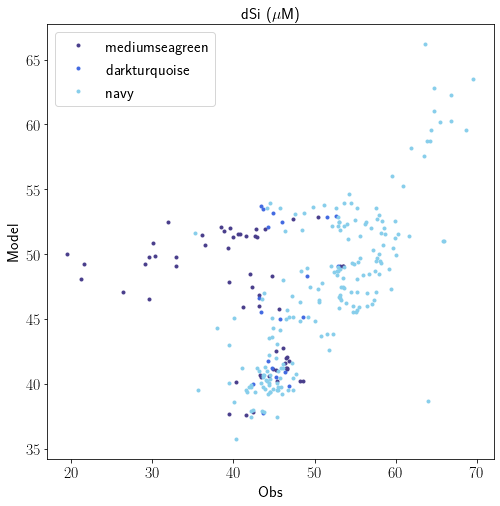

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')

Silicate, z<15
Feb-Mar:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
April:
  N: 60
  bias: 5.894643719991031
  RMSE: 11.771290063713918
  WSS: 0.2774511539938447
May-Jun:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
Sep-Oct:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan


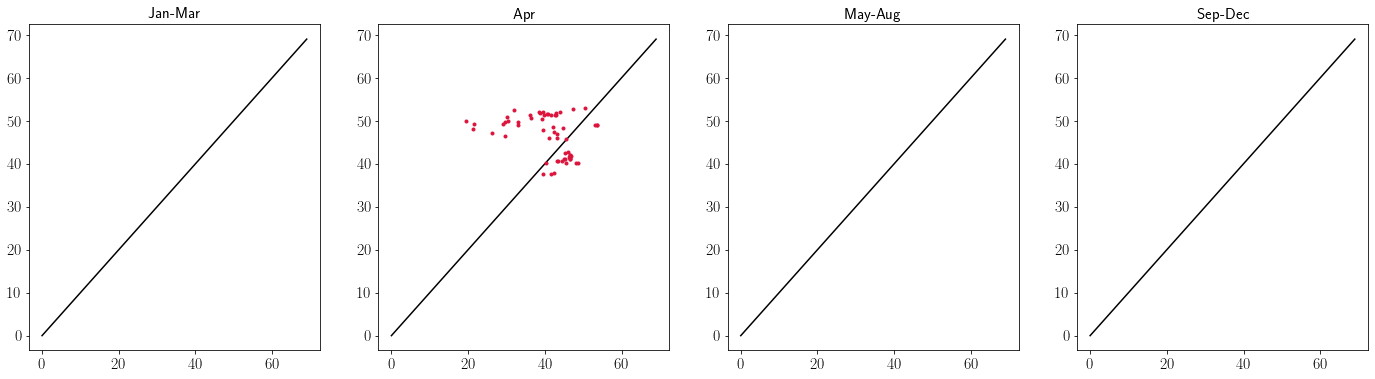

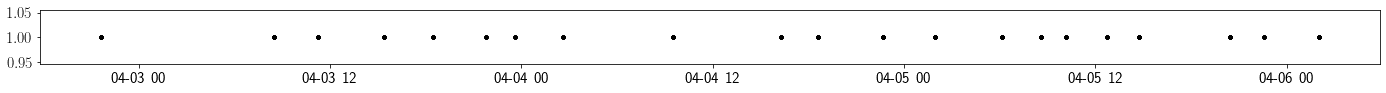

In [17]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Jan-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('Apr')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Aug')
ii3=(data.Z < 15)&(data.dtUTC>dt.datetime(year,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Dec')


print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

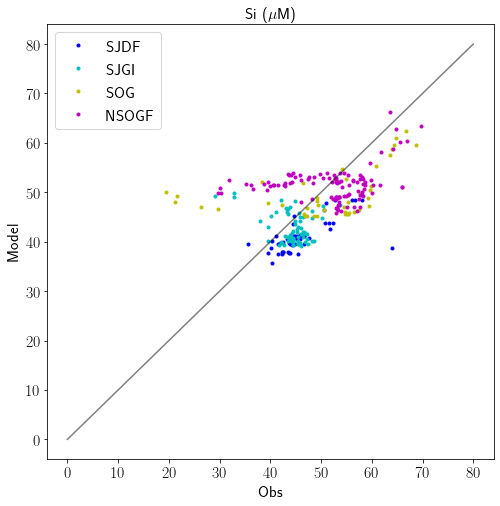

In [18]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')
ax.plot((0,80),(0,80),'k-',alpha=.5)

# Ratios

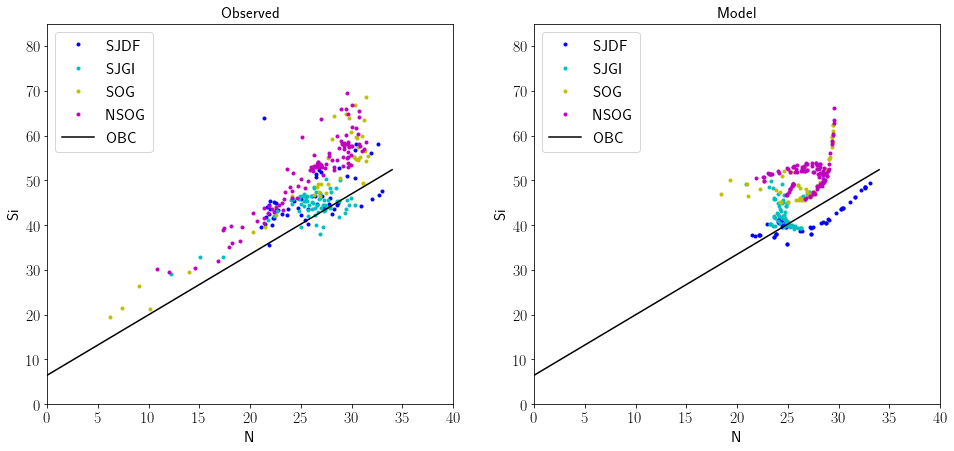

In [19]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].plot(np.arange(0,35),1.35*np.arange(0,35)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].plot(np.arange(0,35),1.35*np.arange(0,35)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

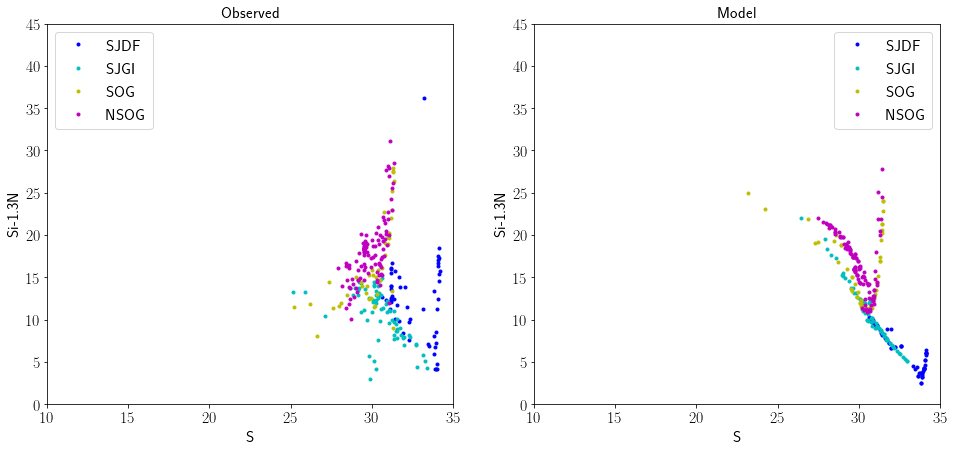

In [20]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('Si-1.3N')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('Si-1.3N')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

# Chlorophyll

In [21]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 47
  bias: -0.23481404525123944
  RMSE: 0.39581349690608614
  WSS: 0.6484585950381876
z>=15 m:
  N: 40
  bias: 0.03591847021183614
  RMSE: 0.26265530225114214
  WSS: 0.43116828216360903
all:
  N: 87
  bias: -0.11033932549810123
  RMSE: 0.34110913674176063
  WSS: 0.7439242192678781


Chl
z<15 m:
  N: 47
  bias: -2.6436033182448533
  RMSE: 5.986850187361638
  WSS: 0.3943724847578851
z>=15 m:
  N: 40
  bias: -0.049740985099691826
  RMSE: 0.5082611805807186
  WSS: 0.2561458890155619
all:
  N: 87
  bias: -1.4510229351896062
  RMSE: 4.413829897801609
  WSS: 0.3311078989663577


Text(0.5, 1.0, 'Chl ($\\mu$g/L)')

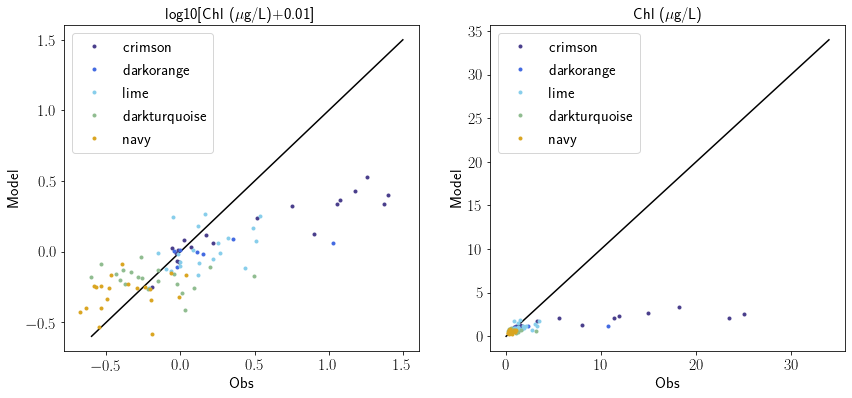

In [22]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')

### Temperature and Salinity

#### By region:

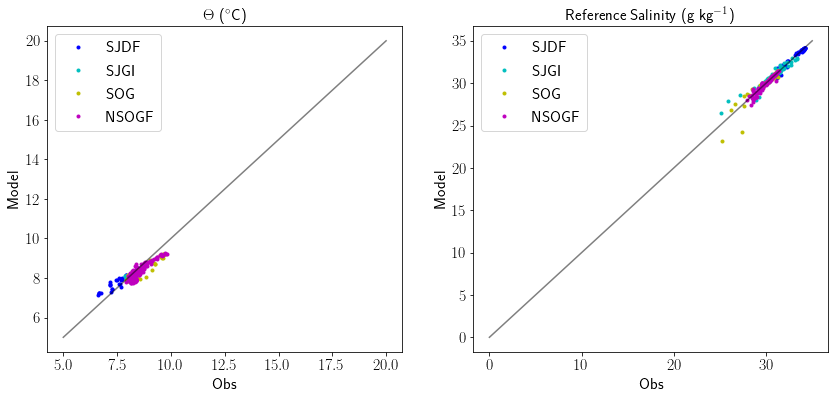

In [23]:
fig, ax = plt.subplots(1,2,figsize = (14,6))

obsvar='ConsT'; modvar='mod_votemper'
ps1=et.varvarPlot(ax[0],dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax[0],dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax[0],dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax[0],dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax[0].legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('$\Theta$ ($^{\circ}$C)')
ax[0].plot((5,20),(5,20),'k-',alpha=.5)

obsvar='AbsSal'; modvar='mod_vosaline'
ps1=et.varvarPlot(ax[1],dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
ps2=et.varvarPlot(ax[1],dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
ps3=et.varvarPlot(ax[1],dSOG,obsvar,modvar,cols=('y',),lname='SOG')
ps4=et.varvarPlot(ax[1],dNSOG,obsvar,modvar,cols=('m',),lname='NSOGF')
ax[1].legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Reference Salinity (g kg$^{-1}$)')
ax[1].plot((0,35),(0,35),'k-',alpha=.5)

#### By Month:

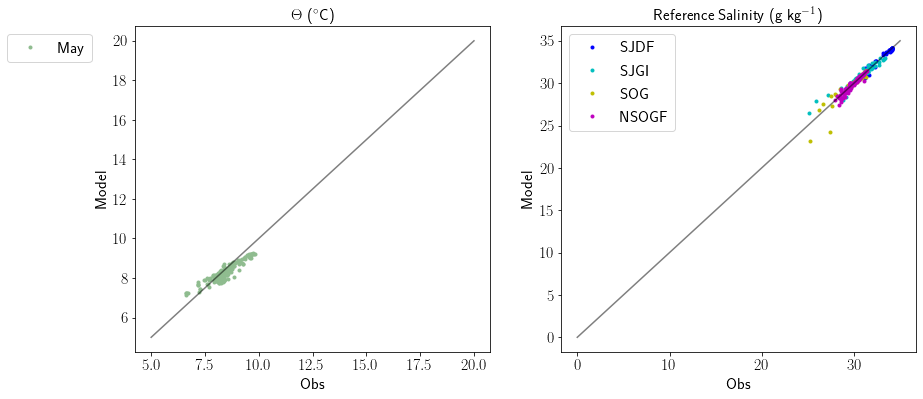

In [34]:
fig, ax = plt.subplots(1,2,figsize = (14,6))

obsvar='ConsT'; modvar='mod_votemper'
ps1=et.varvarPlot(ax[0],data,obsvar,modvar,'Month',np.arange(1,13),
                  labels=('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
ax[0].legend(handles=ps1,bbox_to_anchor=(-.1, 1))
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('$\Theta$ ($^{\circ}$C)')
ax[0].plot((5,20),(5,20),'k-',alpha=.5)

obsvar='AbsSal'; modvar='mod_vosaline'
ps1=et.varvarPlot(ax[1],dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
ps2=et.varvarPlot(ax[1],dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
ps3=et.varvarPlot(ax[1],dSOG,obsvar,modvar,cols=('y',),lname='SOG')
ps4=et.varvarPlot(ax[1],dNSOG,obsvar,modvar,cols=('m',),lname='NSOGF')
ax[1].legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Reference Salinity (g kg$^{-1}$)')
ax[1].plot((0,35),(0,35),'k-',alpha=.5)

### Density

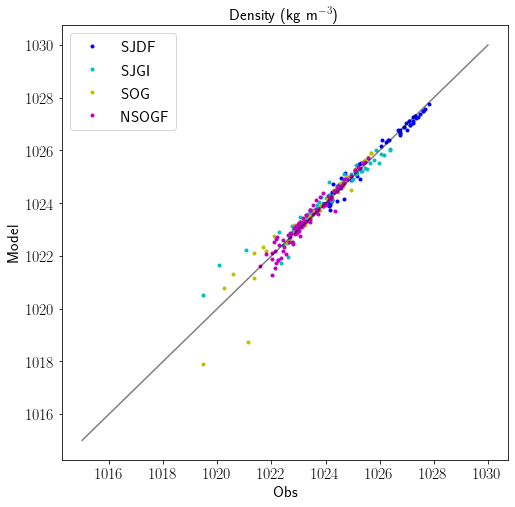

In [25]:

obsvar='rho'; modvar='mod_rho'
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Density (kg m$^{-3}$)')
ax.plot((1015,1030),(1015,1030),'k-',alpha=.5)

### Phys Stats:

In [26]:
print('Conservative Temperature')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'ConsT','mod_votemper')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'ConsT','mod_votemper')
print('all:')
et.printstats(data,'ConsT','mod_votemper')
print('\n')
print('-----------------------')
print('Reference Salinity')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'AbsSal','mod_vosaline')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'AbsSal','mod_vosaline')
print('all:')
et.printstats(data,'AbsSal','mod_vosaline')
print('\n')
print('-----------------------')
print('Density')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'rho','mod_rho')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'rho','mod_rho')
print('all:')
et.printstats(data,'rho','mod_rho')
print('\n')

Conservative Temperature
z<15 m:
  N: 61
  bias: -0.14257212638226413
  RMSE: 0.1960606504772874
  WSS: 0.619533141728375
z>=15 m:
  N: 234
  bias: -0.11929995885745193
  RMSE: 0.2825474847585986
  WSS: 0.9232152522929842
all:
  N: 295
  bias: -0.12411216976936146
  RMSE: 0.26697151175485384
  WSS: 0.9163259140972737


-----------------------
Reference Salinity
z<15 m:
  N: 61
  bias: -0.02629916076792682
  RMSE: 0.7350345451083634
  WSS: 0.9395485623080115
z>=15 m:
  N: 234
  bias: 0.07041927352498689
  RMSE: 0.23398929842371902
  WSS: 0.9928721959229234
all:
  N: 295
  bias: 0.05041986846781299
  RMSE: 0.39388785639879464
  WSS: 0.9851284231189529


-----------------------
Density
z<15 m:
  N: 61
  bias: -0.0011304616318739136
  RMSE: 0.5755464696801926
  WSS: 0.9389491920842918
z>=15 m:
  N: 234
  bias: 0.07235231426875544
  RMSE: 0.19750464225062478
  WSS: 0.9938554586564943
all:
  N: 295
  bias: 0.05715757077723538
  RMSE: 0.31533877210965505
  WSS: 0.9886547376477284


